<a href="https://colab.research.google.com/github/shadab4150/Mura-Stanford-Bone-Xray-abnormalities-detection/blob/master/Mura_Wrist_shoulder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.vision import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange,tqdm
import gc
from graphviz import Digraph
import torch
from torch.autograd import Variable
from torchviz import make_dot

ModuleNotFoundError: ignored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path = Path('/content/');path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/drive'),
 PosixPath('/content/sample_data')]

In [0]:
#!unzip '/content/drive/My Drive/Dataset/MURA-v1.1.zip' -d '/content/'

In [5]:
train = pd.read_csv('/content/drive/My Drive/Dataset/mura_final_4col.csv')
train.sample(n=5)

,is_valid,body_part,path,target
21720,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient06880/study1_p...,1
16879,False,XR_ELBOW,MURA-v1.1/train/XR_ELBOW/patient02208/study1_n...,0
4168,False,XR_SHOULDER,MURA-v1.1/train/XR_SHOULDER/patient01354/study...,1
6342,False,XR_SHOULDER,MURA-v1.1/train/XR_SHOULDER/patient02044/study...,0
37942,True,XR_HAND,MURA-v1.1/valid/XR_HAND/patient11541/study1_po...,1


In [8]:
df = train[train['body_part']=='XR_WRIST'].copy();df.shape

(10411, 4)

In [0]:
def targ(x):
  if x==1:
    return 'abnormal'
  elif x==0:
    return 'normal'

In [0]:
df.target=df.target.apply(targ,convert_dtype=True)

In [0]:
train.target=train.target.apply(targ,convert_dtype=True)

In [15]:
df.sample(n=10)

,is_valid,body_part,path,target
27124,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient08441/study1_n...,normal
26889,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient08373/study1_n...,normal
22564,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient07087/study1_p...,abnormal
19913,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient06413/study1_p...,abnormal
23867,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient07409/study1_p...,abnormal
26742,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient08328/study1_n...,normal
19821,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient06392/study1_p...,abnormal
23401,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient07286/study1_p...,abnormal
26762,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient08334/study1_n...,normal
26516,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient08261/study1_n...,normal


In [0]:
tfms=get_transforms(do_flip=True)

In [0]:
data = (ImageList.from_df(df,path,cols='path')
                .split_from_df(col='is_valid')
                .label_from_df(cols='target')
                .transform(size=256)
                .databunch(bs=128).normalize(imagenet_stats))

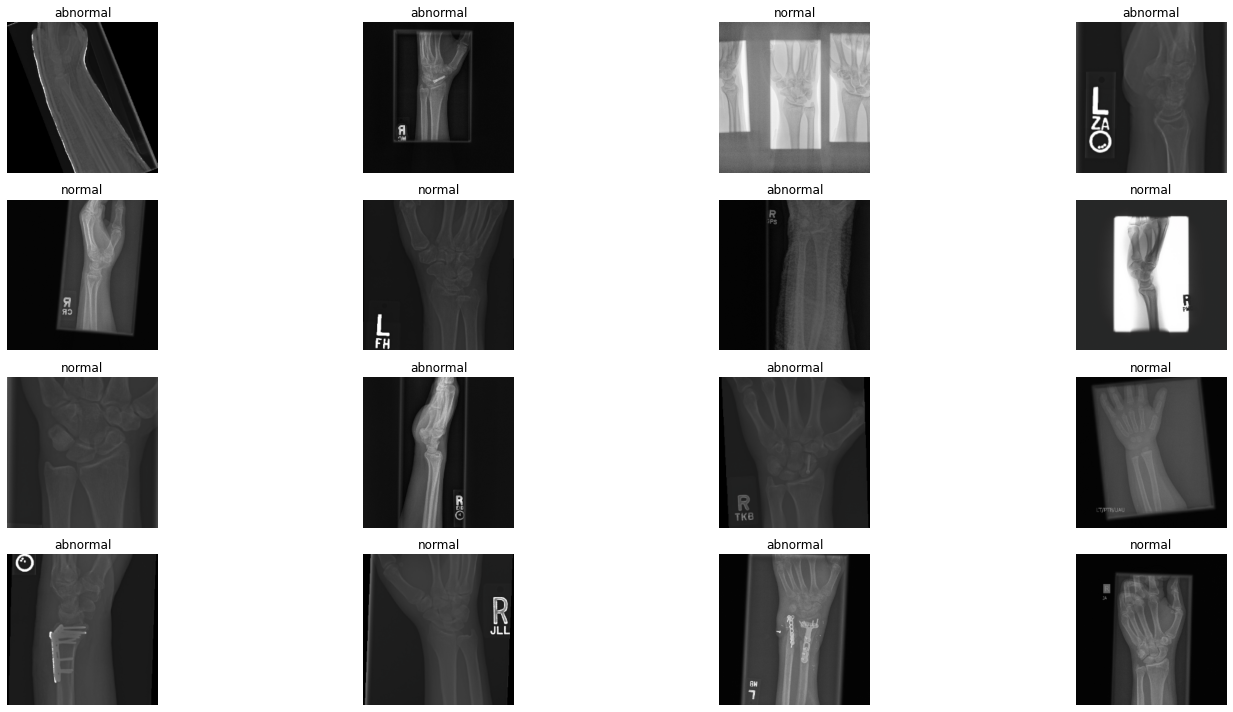

In [14]:
data.show_batch(rows=4,figsize=(22,10))

In [16]:
data.classes,len(data.train_ds),len(data.valid_ds)

(['abnormal', 'normal'], 9752, 659)

# Metrics Kappa Score

In [0]:
kp = KappaScore()
kp.weights = 'quadratic'

In [0]:
learn = cnn_learner(data, models.resnet50,pretrained=False , metrics = [kp] ).to_fp16()

In [38]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
___________________________________________________

In [39]:
gc.collect()

57

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


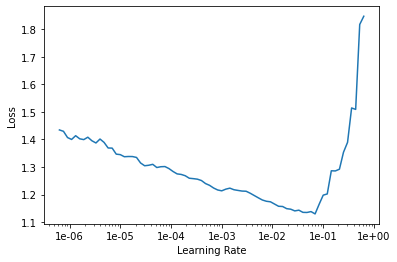

In [40]:
learn.lr_find()
learn.recorder.plot()

In [43]:
gc.collect()

14

In [25]:
np.linspace(1e-3,1e-2,9)

array([0.001   , 0.002125, 0.00325 , 0.004375, 0.0055  , 0.006625, 0.00775 , 0.008875, 0.01    ])

In [42]:
learn.fit_one_cycle(10 , slice(0.00775) , moms=(0.8,0.7) )

epoch,train_loss,valid_loss,kappa_score,time
0,0.992221,0.911977,0.173408,01:31
1,0.821328,0.647383,0.206122,01:33
2,0.757148,0.807986,0.089457,01:31
3,0.699766,0.745244,0.247209,01:31
4,0.630300,0.621730,0.331232,01:31
5,0.571573,1.054432,0.156150,01:31
6,0.521370,0.892101,0.148290,01:30
7,0.470950,0.595732,0.433062,01:31
8,0.410655,0.524997,0.521145,01:31
9,0.298364,0.570735,0.518471,01:32


In [0]:
learn.save('wrist1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


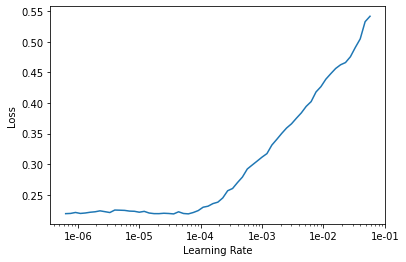

In [44]:
learn.lr_find()
learn.recorder.plot()

In [51]:
gc.collect()

644

In [46]:
np.linspace(1e-5,1e-4,7)

array([1.0e-05, 2.5e-05, 4.0e-05, 5.5e-05, 7.0e-05, 8.5e-05, 1.0e-04])

In [35]:
learn.unfreeze()
learn.fit_one_cycle(8,max_lr=slice(1e-5,1e-4/3))

epoch,train_loss,valid_loss,kappa_score,time
0,0.014560,1.183374,0.649311,01:31
1,0.030250,1.212385,0.660277,01:31
2,0.043037,1.337086,0.650673,01:31
3,0.032280,1.396146,0.653038,01:31
4,0.018367,1.127613,0.689555,01:31
5,0.010339,1.155630,0.673289,01:31
6,0.005475,1.188621,0.685736,01:31
7,0.003555,1.195198,0.682727,01:31


In [52]:
train.body_part.unique()

array(['XR_SHOULDER', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_WRIST', 'XR_FOREARM', 'XR_HAND'], dtype=object)

## ELBOW

In [0]:
data = (ImageList.from_df(train[train['body_part']=='XR_SHOULDER'],path,cols='path')
                .split_from_df(col='is_valid')
                .label_from_df(cols='target')
                .transform(size=256)
                .databunch(bs=128).normalize(imagenet_stats))

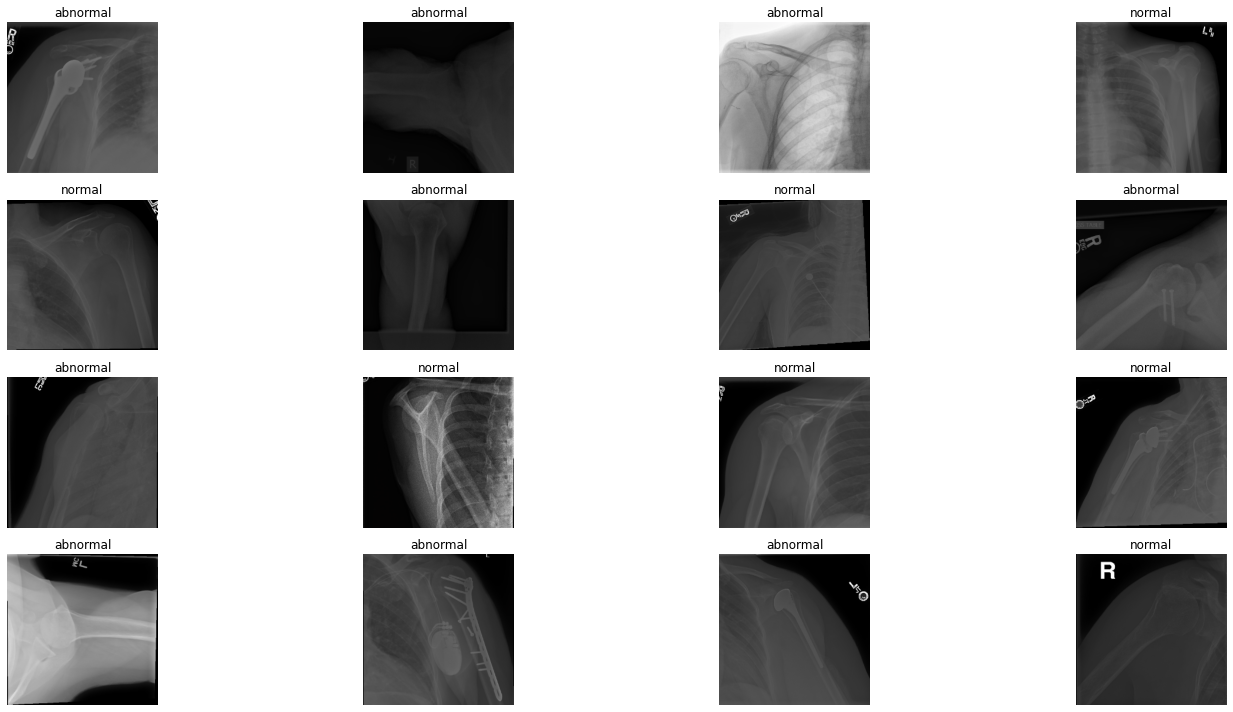

In [54]:
data.show_batch(rows=4,figsize=(22,10))

In [56]:
data.classes,len(data.train_ds),len(data.valid_ds)

(['abnormal', 'normal'], 8379, 563)

In [0]:
learn = cnn_learner(data, models.resnet50,pretrained=True , metrics = [kp] ).to_fp16()

In [58]:
gc.collect()

24028

In [59]:
learn.fit_one_cycle(8,slice(1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,time
0,0.960531,0.719424,0.318917,01:12
1,0.698855,0.607896,0.440928,01:11
2,0.602322,0.580199,0.470681,01:12
3,0.509700,0.580243,0.477924,01:11
4,0.423403,0.669690,0.406841,01:10
5,0.319195,0.767064,0.421253,01:12
6,0.219934,0.807521,0.485118,01:12
7,0.153771,0.833838,0.474489,01:12
